In [143]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

candidates = pd.read_csv('candidates.csv')
candidates.columns

Index(['Candidate Name', 'Riding', 'Party', 'Votes Count', 'Votes Percent',
       'Elected', 'Win Margin Count', 'Win Margin Percent'],
      dtype='object')

In [148]:
plt.rc('font',family='Noto Sans', size=14)

def partyColour(partyList):
    lookup = {'PCP': '#2B328C', 'NDP': '#FF4C00', 'LIB': '#E3102B', 'GPO': '#307730'}
    return [lookup[party] for party in partyList]

def plotBarStyled(x, label_func = lambda x: x, width = 0.5, ymin=0):
    ax = x.plot.bar(color=partyColour(x.index), figsize=(8.5,6), width=width)
    
    ymax = plt.ylim()[1]
    unit = (ymax - ymin)/72
    
    ax.set_ylim(ymin=ymin)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
        if (p.get_height() > 8*unit):
            y_pos = p.get_y() + p.get_height() - 4*unit
            col = 'white'
        else:
            y_pos = p.get_y() + p.get_height() + unit
            col = 'black'
        ax.annotate(label_func(p.get_height()), (p.get_x() + p.get_width() / 2, y_pos), ha='center',
                    size=14, weight=600, color=col)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    
    return ax

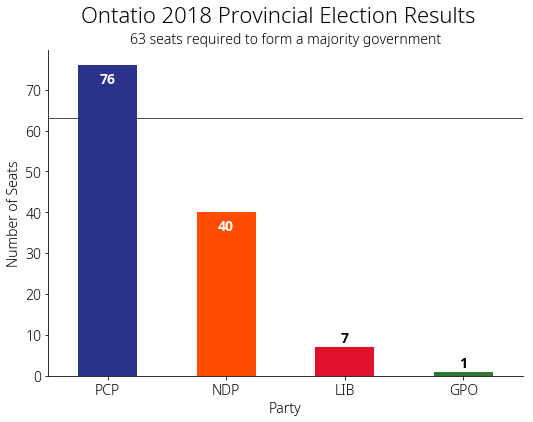

In [3]:
# What were the election counts
x = candidates.loc[candidates['Elected'], 'Party'].value_counts()
 
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel("Number of Seats")
plt.suptitle('Ontatio 2018 Provincial Election Results', size=22)
plt.title('63 seats required to form a majority government', size=14)

ax.axhline(63, color='black', zorder=-1, linewidth=0.7)

Text(0.5,1,'Ontario 2018 Provincial Election')

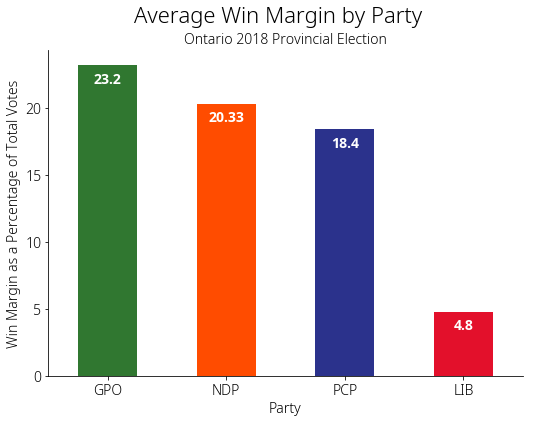

In [4]:
x = candidates.groupby('Party')['Win Margin Percent'].mean().dropna().round(2).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Win Margin as a Percentage of Total Votes')
plt.suptitle('Average Win Margin by Party', size=22)
plt.title('Ontario 2018 Provincial Election', size=14)

## Did the Green Party help the Progressive Conservative Party by splitting votes from the NDP?

In [5]:
#runners_up_indicies = candidates.loc[candidates['Elected'] == False].groupby('Riding')['Votes Count'].idxmax()
#runners_up = candidates.loc[runners_up_indicies].set_index('Riding')
#green_candidates = candidates.loc[candidates['Party'] == 'GPO'].set_index('Riding')
#winners = candidates.loc[candidates['Elected']].set_index('Riding')
runners_up = (candidates.loc[candidates['Elected'] == False]
              .sort_values('Votes Count', ascending=False)
              .drop_duplicates('Riding')
              .set_index('Riding')
              .sort_index())
green_candidates = candidates.loc[candidates['Party'] == 'GPO'].set_index('Riding')
winners = candidates.loc[candidates['Elected']].set_index('Riding')

In [6]:
# Candidates that would have lost had Green Party votes gone to the runner-up
diff_indicies = winners['Win Margin Count'].sub(green_candidates['Votes Count']) < 0
winners.loc[diff_indicies & (winners['Party'] == 'PCP')]

,Candidate Name,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
Riding,,,,,,,
Brampton West,Amarjot Sandhu,PCP,14951,39.4,True,490.0,1.3
Brantford—Brant,Willem Bouma,PCP,24437,42.0,True,635.0,1.1
Cambridge,Belinda Karahalios,PCP,17793,37.0,True,2154.0,4.5
Eglinton—Lawrence,Robin Martin,PCP,19999,40.4,True,957.0,1.9
Kitchener—Conestoga,Michael Harris,PCP,17005,39.6,True,686.0,1.6
Kitchener South—Hespeler,Amy Fee,PCP,16511,38.9,True,770.0,1.8
Ottawa West—Nepean,Jeremy Roberts,PCP,16590,32.8,True,175.0,0.3
Sault Ste. Marie,Rosario Romano,PCP,13498,42.0,True,414.0,1.3
Scarborough—Rouge Park,Vijayadhithyan Thanigasalam,PCP,16224,38.6,True,963.0,2.3


In [7]:
PCP_ridings = candidates.loc[(candidates['Party'] == 'PCP') & candidates['Elected'], 'Riding'].values
if_no_green_votes = pd.Series(runners_up.loc[(winners['Party'] == 'PCP'), 'Votes Count'].add(green_candidates['Votes Count']).values, index=runners_up['Candidate Name'], name='Votes Count')

candidates_no_green = candidates.copy().set_index('Candidate Name')
candidates_no_green.update(if_no_green_votes)
# Drop GPO candidate rows in PCP ridings
candidates_no_green = candidates_no_green[
    (~candidates_no_green['Riding'].isin(PCP_ridings)) |
    (candidates_no_green['Party'] != 'GPO')]

candidates_no_green.loc[candidates_no_green.groupby('Riding')['Votes Count'].idxmax(), 'Party'].value_counts()

PCP    67
NDP    48
LIB     8
GPO     1
Name: Party, dtype: int64

In [8]:
new_winners = candidates_no_green.sort_values('Votes Count', ascending=False).drop_duplicates('Riding')
new_winners.loc[new_winners['Elected'] == False]

,Riding,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
Candidate Name,,,,,,,
Alexandra Felsky,Brantford—Brant,NDP,26543.0,40.9,False,NaN,NaN
Michael Colle,Eglinton—Lawrence,LIB,20232.0,38.4,False,NaN,NaN
Kelly Dick,Kitchener—Conestoga,NDP,19172.0,38.0,False,NaN,NaN
Fitzroy Vanderpool,Kitchener South—Hespeler,NDP,18939.0,37.1,False,NaN,NaN
Marjorie Knight,Cambridge,NDP,18657.0,32.5,False,NaN,NaN
Chandra Pasma,Ottawa West—Nepean,NDP,18352.0,32.5,False,NaN,NaN
Felicia Samuel,Scarborough—Rouge Park,NDP,16275.0,36.3,False,NaN,NaN
Jagroop Pangli,Brampton West,NDP,15460.0,38.1,False,NaN,NaN
Michele McCleave-Kennedy,Sault Ste. Marie,NDP,14128.0,40.7,False,NaN,NaN


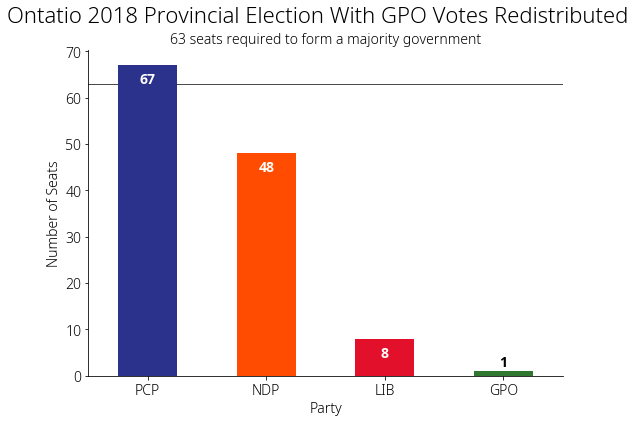

In [9]:
x = new_winners['Party'].value_counts()
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel("Number of Seats")
plt.suptitle('Ontatio 2018 Provincial Election With GPO Votes Redistributed', size=22)
plt.title('63 seats required to form a majority government', size=14)

ax.axhline(63, color='black', zorder=-1, linewidth=0.7)

# Census Data

In [10]:
census = candidates.set_index('Riding').join(pd.read_csv('formatted_census_data.csv', index_col=0))

def w_mean (df, col):
    parties = ['GPO', 'LIB', 'NDP', 'PCP']
    g = df.loc[df['Party'].isin(parties)].assign(w_means=lambda x: x[col] * x['Votes Count']).groupby('Party')
    return (g['w_means'].sum() / g['Votes Count'].sum()).rename(col)

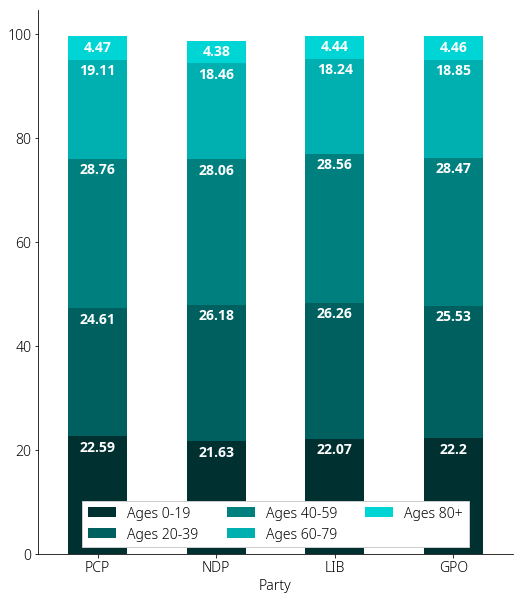

In [11]:
pop_columns = ['Pop. % 0-19', 'Pop. % 20-39', 'Pop. % 40-59', 'Pop. % 60-79', 'Pop. % 80-']
x = pd.concat([census.pipe(w_mean, pop) for pop in pop_columns], axis=1).reindex(index=['PCP', 'NDP', 'LIB', 'GPO'])

ax = x.plot.bar(figsize=(8.5,10), stacked=True, color=['#003030','#006060', '#007F7F', '#00AFAF', '#00D5D5'])

ymax = plt.ylim()[1]
unit = ymax/72

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(p.get_height().round(2), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() - 0.5*unit),
                ha='center', va='top',
                size=14, weight=600, color='white')

for tick in ax.get_xticklabels():
    tick.set_rotation(0)
    
ax.legend(['Ages 0-19', 'Ages 20-39','Ages 40-59','Ages 60-79','Ages 80+'], framealpha=1, ncol=3, fancybox=False, loc='lower center')

Text(0.5,0.98,'Average Population Density of Elected Ridings')

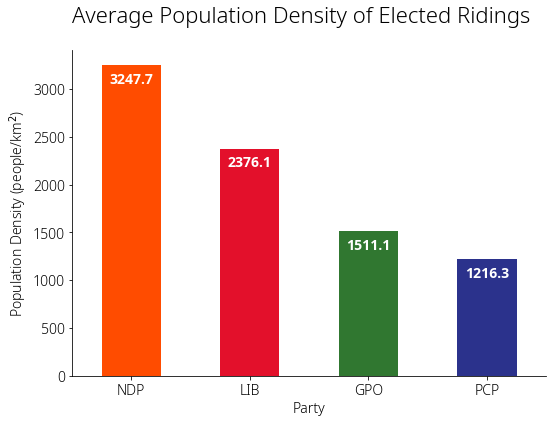

In [12]:
x = census.loc[census['Elected']].groupby('Party')['Pop Density (km^2)'].mean().round(1).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Population Density (people/km$^2$)')
plt.suptitle('Average Population Density of Elected Ridings', size=22)

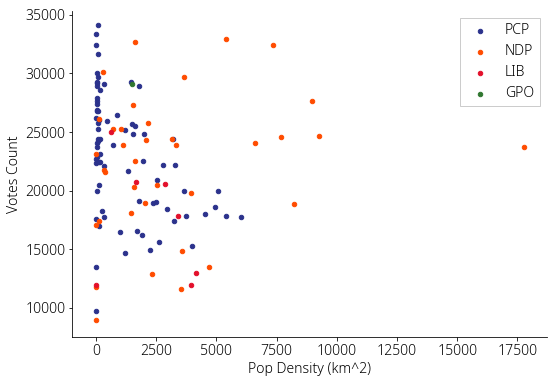

In [13]:
ax = census.loc[(census['Party'] == 'PCP') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Count', figsize=(8.5,6),color='#2B328C')
census.loc[(census['Party'] == 'NDP') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Count', color='#FF4C00', ax=ax)
census.loc[(census['Party'] == 'LIB') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Count', color='#E3102B', ax=ax)
census.loc[(census['Party'] == 'GPO') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Count', color='#307730', ax=ax)

ax.legend(['PCP','NDP','LIB','GPO'], framealpha=1, ncol=1, fancybox=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Text(0.5,0.98,'Average Percentage of Married/Common Law Voters')

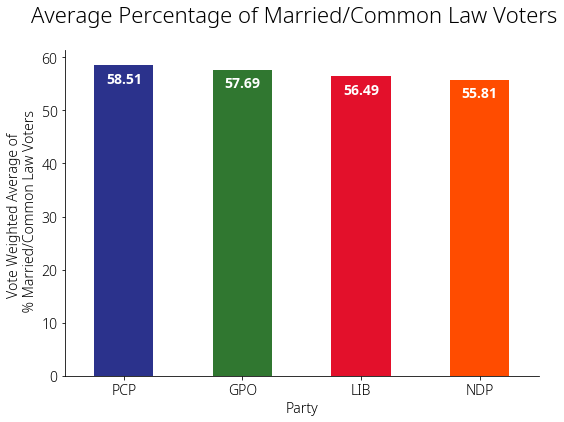

In [14]:
x = census.pipe(w_mean, '% Married/Common Law').round(2).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average of \n % Married/Common Law Voters')
plt.suptitle('Average Percentage of Married/Common Law Voters', size=22)

Text(0.5,0.98,'Average Household Income by Party')

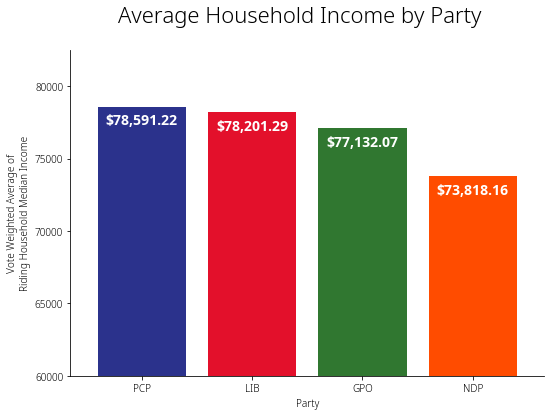

In [147]:
x = census.pipe(w_mean, 'Household Med. Income').sort_values(ascending=False)
ax = plotBarStyled(x, '${:,.2f}'.format, 0.8, 60000)

ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average of\nRiding Household Median Income')

plt.suptitle('Average Household Income by Party', size=22)

Text(100000,62,'r$^2$ = 0.128')

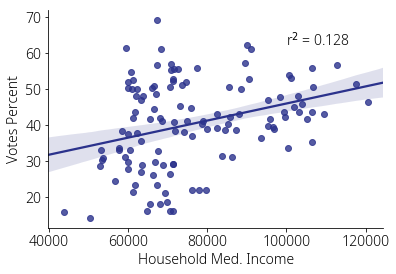

In [149]:
x = census.loc[census['Party'] == 'PCP']
ax = sns.regplot(x['Household Med. Income'], x['Votes Percent'], order=1, color='#2B328C')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

m, b, r, p, err = scipy.stats.linregress(x.loc[ridings, 'Household Med. Income'], x.loc[ridings, 'Votes Percent'])
ax.text(100000, 62, "r$^2$ = " + str(round(r**2, 4)), fontsize = 14)

Text(105000,40,'r$^2$ = 0.1873')

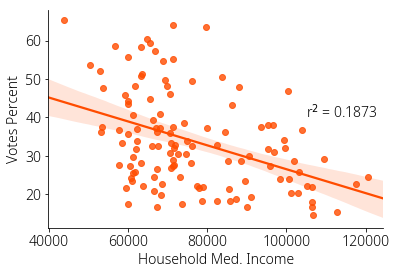

In [152]:
x = census.loc[census['Party'] == 'NDP']
ax = sns.regplot(x['Household Med. Income'], x['Votes Percent'], order=1, color='#FF4C00')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
m, b, r, p, err = scipy.stats.linregress(x.loc[ridings, 'Household Med. Income'], x.loc[ridings, 'Votes Percent'])
ax.text(105000, 40, "r$^2$ = " + str(round(r**2, 4)), fontsize = 14)

In [89]:
ridings = census['Household Med. Income'].dropna().index
df = census.loc[ridings]

ndp = df.loc[df['Party']=='NDP']
ndp_n = ndp['Votes Count'].sum()
ndp_mean = (ndp['Household Med. Income'] * ndp['Votes Count']).sum() / ndp_n
ndp_std = (ndp['Household Med. Income'] * ndp['Votes Count']).std()

pcp = df.loc[df['Party']=='PCP']
pcp_n = pcp['Votes Count'].sum()
pcp_mean = (pcp['Household Med. Income'] * pcp['Votes Count']).sum() / pcp_n
pcp_std = (pcp['Household Med. Income'] * pcp['Votes Count']).std()

print(ttest_ind_from_stats(mean1=ndp_mean, std1=ndp_std, nobs1=ndp_n,
                     mean2=pcp_mean, std2=pcp_std, nobs2=pcp_n))

from scipy import stats
winners = census.loc[census['Elected']].dropna()
a = winners.loc[winners['Party'] == 'PCP', 'Household Med. Income']
b = winners.loc[winners['Party'] == 'NDP', 'Household Med. Income']
stats.ttest_ind(a, b)
#sns.distplot(ndp['Household Med. Income'].dropna(), hist_kws={'weights': ndp.loc[ndp['Household Med. Income'].dropna().index, 'Votes Count']})

#(ndp['Household Med. Income'].mean(), pcp['Household Med. Income'].mean())

Ttest_indResult(statistic=-0.01932379547333257, pvalue=0.9845828015658222)


Ttest_indResult(statistic=4.552825447071494, pvalue=1.3630232445006566e-05)

Text(0.5,0.98,'Average Immigrant Percentage of Riding Population by Party')

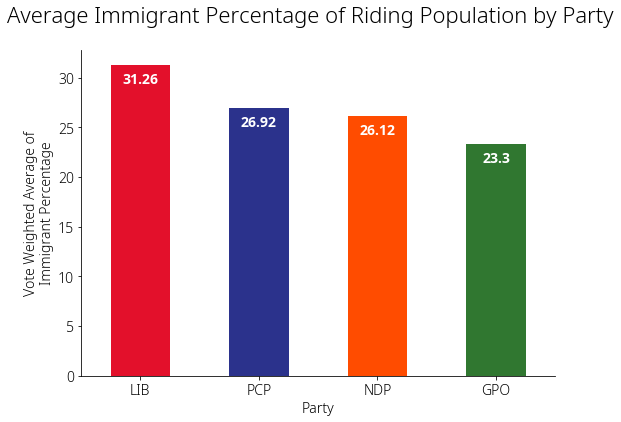

In [20]:
x = census.pipe(w_mean, '% Immigrant').sort_values(ascending=False).round(2)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average of\nImmigrant Percentage')

plt.suptitle('Average Immigrant Percentage of Riding Population by Party', size=22)